## Installation required in Colab

In [1]:
! git clone https://github.com/shaoanlu/diffusion_policy_quadrotor.git

Cloning into 'diffusion_policy_quadrotor'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 155 (delta 66), reused 111 (delta 38), pack-reused 0
Receiving objects: 100% (155/155), 4.19 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [2]:
%cd diffusion_policy_quadrotor
%ls

/content/diffusion_policy_quadrotor
assets/  config/  core/  demo.ipynb  LICENSE  pyproject.toml  README.md  utils/


In [3]:
%%capture
!pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 jax==0.4.23 jaxlib==0.4.23

## Description

This notebook demonstrate using a diffusion policy controller to drive a quadrotor moving from (0, 0) to (5, 5) with random circle obstacles presented.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import os
import torch
import yaml
import collections
from tqdm.auto import tqdm
import gdown

/home/yif/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.normalizers import LinearNormalizer
from core.controllers.quadrotor_diffusion_policy import QuadrotorDiffusionPolicy, build_networks_from_config, build_noise_scheduler_from_config
from core.controllers.quadrotor_clf_cbf_qp import QuadrotorCLFCBFController
from core.env.planar_quadrotor import PlanarQuadrotorEnv
from utils.visualization import visualize_quadrotor_simulation_result

## Load the config file

In [46]:
with open("config/config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Whether to use a finetuned model trained following tricks mentioned in
# [Fine-Tuning Image-Conditional Diffusion Models is Easier than You Think](https://arxiv.org/abs/2409.11355)
use_single_step_inference = config.get("controller").get("common").get("use_single_step_inference", False)

## Instantiate the controller

In [47]:
clf_cbf_controller = QuadrotorCLFCBFController(config=config)

controller = QuadrotorDiffusionPolicy(
    model=build_networks_from_config(config),
    noise_scheduler=build_noise_scheduler_from_config(config),
    normalizer=LinearNormalizer(),
    clf_cbf_controller=None,  # set as clf_cbf_controller to enable CLF-CBF traj refinement
    config=config,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

## Download and load pretrained weights

In [48]:
# download pretrained weights from Google drive
if use_single_step_inference:
    ckpts_path = "ema_noise_pred_net2_ph96_oh2_ah10_v8_singlestepFT.ckpt"
    if not os.path.isfile(ckpts_path):
        gdown.download(id="1UhxlzoQ6DOt0HZhokzU4ktl2MfzlA2Ii", output=ckpts_path, quiet=False)
else:
    ckpts_path = "ema_noise_pred_net2_ph96_oh2_ah10_v8.ckpt"
    if not os.path.isfile(ckpts_path):
        gdown.download(id="1-as6EqMLECxU7IVLZZIEDAcXMox_RkI_", output=ckpts_path, quiet=False)

# load weights
controller.load_weights(ckpts_path)

## Instantiate the simulator

In [49]:
sim = PlanarQuadrotorEnv(config)

## Run simulation

In [50]:
def generate_random_obstacles():
    num_obstacles = np.random.randint(1, 8)
    obs_center, obs_radius = np.empty((num_obstacles, 2)), np.ones((num_obstacles,))
    for obs_idx in range(num_obstacles):  # set XY position of each obstacle
        obs_center[obs_idx, ...] = np.random.randint(1, 8, size=(2,))
        obs_radius[obs_idx] = np.random.uniform(0.2, 1.5)
    return obs_center, obs_radius

def encode_obstacle_info(obs_center: np.ndarray, obs_radius: np.ndarray):
    obs_encode = np.zeros((7, 7))
    for center, radius in zip(obs_center, obs_radius):
        obs_encode[tuple((center-1).astype(np.int32))] = radius
    obs_encode = obs_encode.flatten()
    return obs_encode

In [74]:
np.random.seed(12)

# Env parameters
max_steps = 400
dt = 0.01
ratio_sim_ts = 10  # ratio of sampling time between the simulator and the controller

# get first observation
state = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # [y, y_dot, z, z_dot, phi, phi_dot]
states = [state]  # `states` is a list containing the states over time
controls = [np.array([0, 0])]
obs_center, obs_radius = generate_random_obstacles()
obs_encode = encode_obstacle_info(obs_center, obs_radius)
obs = {
    "state": collections.deque([state] * controller.obs_horizon, maxlen=controller.obs_horizon),
    "obs_encode": [obs_encode],
    "obs_center": obs_center,
    "obs_radius": obs_radius,
}

# termimnation params
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval") as pbar:
    while not done:
        # controller inference
        action = controller.predict_action(obs)

        # execute action_horizon steps without replanning
        print(f"Step {step_idx}: action: {action.shape}", max_steps)
        for i in range(action.shape[0]):
            # stepping env
            command = controller.calculate_force_command(state, action[i])
            for _ in range(ratio_sim_ts):
                state = sim.step(state, command, dt=dt/ratio_sim_ts)
            # save observations and controls
            obs["state"].append(state.copy())
            states.append(state.copy())
            controls.append(action[i].copy())

            # update progress bar
            step_idx += 1
            pbar.update(1)
            if step_idx > max_steps:
                done = True
            if done:
                break

Eval: 401it [00:00, 3496.44it/s]                         

Step 0: action: (95, 6) 400
Step 95: action: (95, 6) 400
Step 190: action: (95, 6) 400
Step 285: action: (95, 6) 400
Step 380: action: (95, 6) 400


## Visualize result

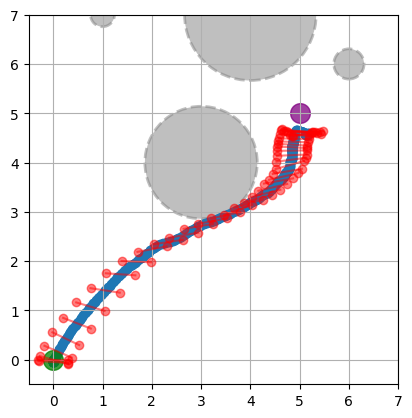

In [75]:
states = np.array(states)
visualize_quadrotor_simulation_result(sim, states, obs_center=obs_center, obs_radius=obs_radius)